In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import json
import numpy as np
import re
import string
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import regex
from nltk.translate.bleu_score import corpus_bleu
from nltk.tokenize import word_tokenize
from tqdm import tqdm
import unicodedata
import torch.optim as optim
import copy

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lang_pair="English-Hindi"

In [ ]:
input_directory="/kaggle/input/embeddings"

train_file_path = input_directory+"/train_data.json"
train_data = pd.read_json(train_file_path)

test_file_path = input_directory+"/test_data.json"
test_data = pd.read_json(test_file_path)

for language_pair, language_data in train_data.items():
  print(f"Language Pair: {language_pair}")

for language_pair, language_data in test_data.items():
  print(f"Language Pair: {language_pair}")


source_lang=lang_pair.split("-")[0]
target_lang=lang_pair.split("-")[1]

Language Pair: English-Bengali
Language Pair: English-Hindi
Language Pair: English-Bengali
Language Pair: English-Hindi


In [4]:
def get_sentence_pairs(data,lang_pair,d_type):
    source_sentences=[]
    target_sentences=[]
    id_values=[]
    for language_pair, language_data in data.items():
        if(language_pair == lang_pair):
          print(f"Language Pair: {language_pair}")
          for data_type, data_entries in language_data.items():
              print(f"  Data Type: {data_type}")
              for entry_id, entry_data in data_entries.items():
                  source = entry_data["source"]
                  if "target" in entry_data:
                      target = entry_data["target"]
                    
                  if (data_type == d_type):
                    source_sentences.append(source)
                    if "target" in entry_data:
                        target_sentences.append(target)
                    id_values.append(entry_id)

    return source_sentences,target_sentences,id_values



In [5]:
def create_validation_set(source_sentences_train, target_sentences_train,id_train, val_ratio):
    # Define split ratio
    n_train = len(source_sentences_train)
    n_val = int(n_train * val_ratio)
    
    # Create validation subset
    source_sentences_val = source_sentences_train[:n_val]
    target_sentences_val = target_sentences_train[:n_val]
    id_val = id_train[:n_val]
    
    # Keep the remaining as training
    source_sentences_train = source_sentences_train[n_val:]
    target_sentences_train = target_sentences_train[n_val:]
    id_train = id_train[n_val:]

    return source_sentences_train, target_sentences_train, id_train, source_sentences_val, target_sentences_val, id_val

In [6]:
def preprocess_hindi_text(sentence):
    text = unicodedata.normalize("NFKC", sentence)
    text = re.sub(r"[^\u0900-\u097F\s]", " ", text)  # keep Devanagari + spaces
    text = re.sub(r"[\u0966-\u096F]", " ", text)     # remove Hindi digits

    hindi_only_pattern = re.compile(r'^[\u0900-\u097F]+$')
    tokens = text.strip().split()
    clean_tokens = [tok for tok in tokens if hindi_only_pattern.match(tok)]

    return nltk.word_tokenize(" ".join(clean_tokens))

In [ ]:
def preprocess_bengali_text(sentence: str) -> str:
    text = unicodedata.normalize("NFKC", sentence)
    text = re.sub(r"[^\u0980-\u09FF\s]", " ", text)
    bengali_only_pattern = re.compile(r'^[\u0980-\u09FF]+$')
    tokens = text.strip().split()
    clean_tokens = [tok for tok in tokens if bengali_only_pattern.match(tok)]
    return nltk.word_tokenize(" ".join(clean_tokens))

In [8]:
import nltk
from collections import Counter
import unicodedata


def truncate_sentences(sentences,max_length):
    sentences=[sent[:max_length] for sent in sentences]
    return sentences

def preprocess_english_text(sentence):
    text = unicodedata.normalize("NFKC", sentence)
    # Keep only Latin letters and whitespace
    text = re.sub(r"[^A-Za-z\s]", " ", text)
    english_only_pattern = re.compile(r'^[A-Za-z]+$')
    tokens = text.strip().split()
    clean_tokens = [tok for tok in tokens if english_only_pattern.match(tok)]
    return nltk.word_tokenize(" ".join(clean_tokens))

# Tokenization and Lowercasing
def preprocess(sentences,lang):
    if lang=="English":
        tokenized_sentences = [preprocess_english_text(sentence.lower()) for sentence in sentences]
    elif lang=="Hindi":
        tokenized_sentences = [preprocess_hindi_text(sentence.lower()) for sentence in sentences]
    elif lang=="Bengali":
        tokenized_sentences = [preprocess_bengali_text(sentence.lower()) for sentence in sentences]
    else:
        throw ("lang not supported")

    return tokenized_sentences

def encode_and_pad(vocab, sent, max_length):
    sos = [vocab["<SOS>"]]
    eos = [vocab["<EOS>"]]
    pad = [vocab["<PAD>"]]
    unk = vocab["<UNK>"]

    encoded = [vocab.get(w, unk) for w in sent]

    if len(encoded) < max_length - 2:  # -2 for SOS and EOS
        n_pads = max_length - 2 - len(encoded)
        return sos + encoded + eos + pad * n_pads
    else:  # Truncate if longer than max_length
        truncated = encoded[:max_length - 2]
        return sos + truncated + eos

def process_data(train_data, test_data, lang_pair):
    source_sentences_train, target_sentences_train, id_train=get_sentence_pairs(train_data,lang_pair,"Train")
    source_sentences_test, target_sentences_test, id_test=get_sentence_pairs(test_data,lang_pair,"Test")
    print(f"Length of initial training data: {len(source_sentences_train)}")
    print(f"Length of test data: {len(source_sentences_test)}")

    source_sentences_train, target_sentences_train, id_train, source_sentences_val, target_sentences_val, id_val=create_validation_set(
        source_sentences_train, target_sentences_train, id_train,0.01)

    source_tokens_train = preprocess(source_sentences_train,source_lang)
    source_tokens_test = preprocess(source_sentences_test,source_lang)
    source_tokens_val=preprocess(source_sentences_val,source_lang)

    target_tokens_train = preprocess(target_sentences_train,target_lang)
    target_tokens_val=preprocess(target_sentences_val,target_lang)

    
    lengths = [len(sent) for sent in source_tokens_train]
    lengths = np.array(lengths)
    
    print(f"Number of sentences: {len(lengths)}")
    print(f"Average length: {np.mean(lengths):.2f} tokens")
    print(f"Median length: {np.median(lengths)} tokens")
    print(f"Max length: {np.max(lengths)} tokens")
    print(f"Min length: {np.min(lengths)} tokens")
    
    for p in [90, 95, 99]:
        print(f"{p}th percentile length: {np.percentile(lengths, p):.0f} tokens")
    
    
    # Optional: visualize
    plt.hist(lengths, bins=50, color='steelblue', alpha=0.7)
    plt.title("Distribution of Source Sentence Lengths")
    plt.xlabel("Sentence length (tokens)")
    plt.ylabel("Number of sentences")
    plt.show()

    lengths = [len(sent) for sent in target_tokens_train]
    lengths = np.array(lengths)    
    print(f"Number of sentences: {len(lengths)}")
    print(f"Average length: {np.mean(lengths):.2f} tokens")
    print(f"Median length: {np.median(lengths)} tokens")
    print(f"Max length: {np.max(lengths)} tokens")
    print(f"Min length: {np.min(lengths)} tokens")

    
    for p in [90, 95, 99]:
        print(f"{p}th percentile length: {np.percentile(lengths, p):.0f} tokens")

    
    # Optional: visualize
    plt.hist(lengths, bins=50, color='steelblue', alpha=0.7)
    plt.title("Distribution of Source Sentence Lengths")
    plt.xlabel("Sentence length (tokens)")
    plt.ylabel("Number of sentences")
    plt.show()
    

    max_length=30
    source_tokens_train=truncate_sentences(source_tokens_train,max_length)
    target_tokens_train=truncate_sentences(target_tokens_train,max_length)
    source_tokens_val=truncate_sentences(source_tokens_val,max_length)
    target_tokens_val=truncate_sentences(target_tokens_val,max_length)
    source_tokens_test=truncate_sentences(source_tokens_test,max_length)

    print((source_sentences_train[0]))
    print((source_sentences_test[0]))
    print((source_sentences_val[0]))
    print((target_sentences_train[0]))
    print((target_sentences_val[0]))

    print(source_tokens_train[0])
    print(source_tokens_test[0])
    print(source_tokens_val[0])
    print(target_tokens_train[0])
    print(target_tokens_val[0])
    

    
    source_index2word = ["<PAD>", "<SOS>", "<EOS>","<UNK>"]
    target_index2word = ["<PAD>", "<SOS>", "<EOS>","<UNK>"]


    temp=[]
    temp.extend(source_tokens_train)
    all_tokens = [token for sent in temp for token in sent]
    
    token_counts = Counter(all_tokens)    
    temp = [token for token, freq in token_counts.items() if freq >= 1]
    source_index2word.extend(temp)



    temp=[]
    temp.extend(target_tokens_train)
    all_tokens = [token for sent in temp for token in sent]
    token_counts = Counter(all_tokens)
    
    temp = [token for token, freq in token_counts.items() if freq >= 1]
    target_index2word.extend(temp)
    
    source_word2index = {token: idx for idx, token in enumerate(source_index2word)}
    target_word2index = {token: idx for idx, token in enumerate(target_index2word)}

    print(f"max seq length used for sentences: {max_length}")
    source_train_encoded = [encode_and_pad(source_word2index, sent, max_length) for sent in source_tokens_train]
    source_val_encoded = [encode_and_pad(source_word2index, sent, max_length) for sent in source_tokens_val]
    source_test_encoded = [encode_and_pad(source_word2index, sent, max_length) for sent in source_tokens_test]
    
    target_train_encoded = [encode_and_pad(target_word2index, sent, max_length) for sent in target_tokens_train]
    target_val_encoded = [encode_and_pad(target_word2index, sent, max_length) for sent in target_tokens_val]
    
    print(source_train_encoded[1])
    
    batch_size = 64
    
    train_x = np.array(source_train_encoded)
    train_y = np.array(target_train_encoded)
    
    val_x = np.array(source_val_encoded)
    val_y = np.array(target_val_encoded)
    
    test_x = np.array(source_test_encoded)
    
    
    
    train_ds = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
    val_ds = TensorDataset(torch.from_numpy(val_x))
    test_ds = TensorDataset(torch.from_numpy(test_x))
    
    train_dl = DataLoader(train_ds, shuffle=True, batch_size=batch_size, drop_last=True)
    return train_dl, val_ds, test_ds, source_word2index, source_index2word, target_word2index, target_index2word,target_sentences_val

Language Pair: English-Hindi
  Data Type: Train
Language Pair: English-Hindi
  Data Type: Test
Length of initial training data: 80797
Length of test data: 23085
Number of sentences: 79990
Average length: 16.43 tokens
Median length: 15.0 tokens
Max length: 258 tokens
Min length: 0 tokens
90th percentile length: 28 tokens
95th percentile length: 33 tokens
99th percentile length: 45 tokens


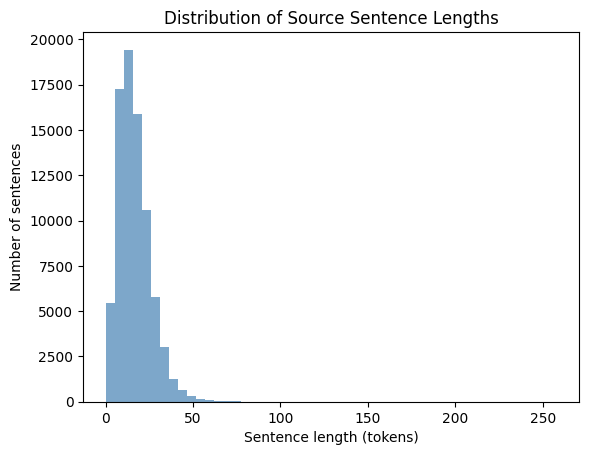

Number of sentences: 79990
Average length: 18.34 tokens
Median length: 17.0 tokens
Max length: 216 tokens
Min length: 0 tokens
90th percentile length: 31 tokens
95th percentile length: 37 tokens
99th percentile length: 50 tokens


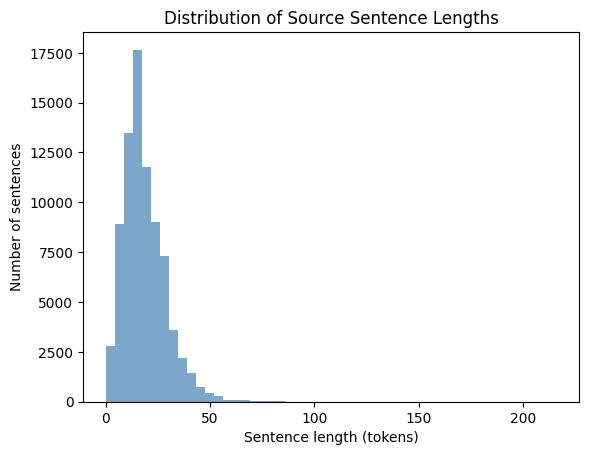

So, this is the input that I have given cars underscore data dot isnull dot sum that will give me the missing values present in each column.
And then we need to assure students that a computer can perform all the steps that are used in manual logarithms, and so whatever manual algorithm you have we can somehow feed to a computer as well.
cancel everything on my calendar
यह इनपुट है जो मैंने cars_data.isnull.sum() को दिया है जो मुझे प्रत्येक कॉलम में मौजूद ((मिसिंग वैल्यूज़ |missing values)) दे देंगे।
मेरे कैलेंडर पर सब कुछ रद्द करें
['so', 'this', 'is', 'the', 'input', 'that', 'i', 'have', 'given', 'cars', 'underscore', 'data', 'dot', 'isnull', 'dot', 'sum', 'that', 'will', 'give', 'me', 'the', 'missing', 'values', 'present', 'in', 'each', 'column']
['and', 'then', 'we', 'need', 'to', 'assure', 'students', 'that', 'a', 'computer', 'can', 'perform', 'all', 'the', 'steps', 'that', 'are', 'used', 'in', 'manual', 'logarithms', 'and', 'so', 'whatever', 'manual', 'algorithm', 'you', 'have', 

In [9]:
train_dl, val_ds, test_ds, source_word2index, source_index2word, target_word2index, target_index2word,target_sentences_val=process_data(train_data,test_data,lang_pair)

In [12]:
import torch
import torch.nn as nn
import math
import torch.nn.functional as F


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x


class TransformerModel(nn.Module):
    def __init__(self, src_embedding_layer, tgt_embedding_layer, d_model, nhead, num_encoder_layers, num_decoder_layers, target_vocab_size):
        super().__init__()
        self.src_embedding = src_embedding_layer   # encoder embeddings
        self.tgt_embedding = tgt_embedding_layer   # decoder embeddings

        if src_embedding_layer.embedding_dim!=d_model:  # since pre trained embeddings size is 300, through this we map to arbitrary length
            self.src_proj = nn.Linear(src_embedding_layer.embedding_dim, d_model, bias=False)
            self.tgt_proj = nn.Linear(tgt_embedding_layer.embedding_dim, d_model, bias=False)

        self.pos_encoder = PositionalEncoding(d_model)
        self.dropout = nn.Dropout(p=0.2) 
        
        self.transformer = nn.Transformer(
            d_model=d_model, nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            batch_first=True,
            dropout=0.2,
            dim_feedforward=d_model*4,
            #norm_first=True,
            #activation=F.gelu 
        
        )
        self.fc_out = nn.Linear(d_model, target_vocab_size)
        self.d_model=d_model

        
        

    def make_tgt_mask(self, tgt):
        '''
        Creates a triangular mask for the target sequence.
        Prevents decoder from looking ahead.
        '''
        seq_len = tgt.size(1)
        mask = torch.triu(torch.ones((seq_len, seq_len), device=tgt.device), diagonal=1)
        mask = mask.masked_fill(mask == 1, float('-inf'))
        return mask

    def forward(self, src, tgt):
        value = getattr(self, 'src_proj', None)
        if value is None:
            src_emb = self.src_embedding(src)
            tgt_emb = self.tgt_embedding(tgt)
        else:
            src_emb = self.src_proj(self.src_embedding(src)) 
            tgt_emb = self.tgt_proj(self.tgt_embedding(tgt)) 

        src_emb = self.pos_encoder(src_emb)
        tgt_emb = self.pos_encoder(tgt_emb)
  
        src_emb = self.dropout(src_emb) 
        tgt_emb = self.dropout(tgt_emb) 

        tgt_mask = self.make_tgt_mask(tgt)

        output = self.transformer(
            src_emb, tgt_emb,
            src_key_padding_mask=(src==0),   
            tgt_key_padding_mask=(tgt==0),   
            tgt_mask=tgt_mask                 
        )
        return self.fc_out(output)


In [13]:
import numpy as np

def get_embeddings(embedding_dim,source_word2index, target_word2index):
    source_embedding_matrix = np.random.normal(
        loc=0.0,
        scale=1/np.sqrt(embedding_dim),
        size=(len(source_word2index), embedding_dim)
    ).astype(np.float32)
    
    target_embedding_matrix = np.random.normal(
        loc=0.0,
        scale=1/np.sqrt(embedding_dim),
        size=(len(target_word2index), embedding_dim)
    ).astype(np.float32)

    glove = {}
    with open(f"/kaggle/input/embeddings/glove.6B.{embedding_dim}d.txt", "r", encoding="utf8") as f:
        for line in f:
            parts = line.strip().split()
            word = parts[0]
            vector = np.asarray(parts[1:], dtype="float32")
            glove[word] = vector
    
    
    i=0
    j=0
    
    for word, idx in source_word2index.items():
        if word in glove:
            i+=1
            source_embedding_matrix[idx] = glove[word]
        else:
            j+=1

    print(f"Number of source words found: {i}")
    print(f"Number of source words missing: {j}")

    fasttext = {}
    embeddings_file=None

    # we use fast text wiki embeddings for hindi but use common crawl for Bengali since
    # wiki version has lot of missing words
    
    if target_lang=="Hindi":
        embeddings_file="/kaggle/input/embeddings/wiki.hi.vec"
    elif target_lang=="Bengali":
        embeddings_file="/kaggle/input/embeddings/cc.bn.300.vec"
        
    with open(embeddings_file, "r", encoding="utf8") as f:
        for line in f:
            try:
                parts = line.strip().split()
                word = parts[0]
                vector = np.asarray(parts[1:], dtype="float32")
                fasttext[word] = vector
            except:
                continue

    i=0
    j=0
    for word, idx in target_word2index.items():
        if word in fasttext:
            target_embedding_matrix[idx] = fasttext[word]
            i+=1
        else:
            j+=1
            
    print(f"Number of target words found: {i}")
    print(f"Number of target words missing: {j}")
    return source_embedding_matrix, target_embedding_matrix


def calculate_bleu_score(target_lang):
    target_tokens_val=preprocess(target_sentences_val,target_lang)
    references = [[tokens] for tokens in target_tokens_val]
    hypotheses = [word_tokenize(hyp) for hyp in val_outs]
    bleu_score = corpus_bleu(references, hypotheses)    
    print(f"BLEU score: {bleu_score}")
    return bleu_score


In [14]:
# beam search based inferencing
def infer_transformer(
    model,
    test_ds,
    target_index2word,
    target_word2index,
    device,
    beam_size: int = 5,
    max_target_len: int = 20,
    length_penalty: float = 1.0,
):
    PAD_IDX = 0
    SOS_IDX = target_word2index["<SOS>"]
    EOS_IDX = target_word2index["<EOS>"]

    model.eval()
    outputs = []

    for i in tqdm(range(len(test_ds))):
        src_tensor = test_ds[i][0].unsqueeze(0).to(device).long()
        src_mask = (src_tensor == PAD_IDX).to(device)

        # Encode source sequence once
        with torch.no_grad():
            projection = getattr(model, "src_proj", None)
            if projection is None:
                src_emb = model.pos_encoder(model.src_embedding(src_tensor))
            else:
                src_emb = model.pos_encoder(model.src_proj(model.src_embedding(src_tensor)))

            memory = model.transformer.encoder(src_emb, src_key_padding_mask=src_mask)

        # Initialize beam
        beams = [(torch.tensor([[SOS_IDX]], device=device), 0.0)]

        for _ in range(max_target_len):
            new_beams = []
            for seq, score in beams:
                if seq[0, -1].item() == EOS_IDX:
                    new_beams.append((seq, score))
                    continue

                tgt_mask = model.make_tgt_mask(seq)
                tgt_pad_mask = (seq == PAD_IDX).to(device)

                with torch.no_grad():
                    if projection is None:
                        tgt_emb = model.pos_encoder(model.tgt_embedding(seq))
                    else:
                        tgt_emb = model.pos_encoder(model.tgt_proj(model.tgt_embedding(seq)))

                    decoder_out = model.transformer.decoder(
                        tgt_emb,
                        memory,
                        tgt_mask=tgt_mask,
                        tgt_key_padding_mask=tgt_pad_mask,
                        memory_key_padding_mask=src_mask,
                    )
                    logits = model.fc_out(decoder_out[:, -1, :])
                    log_probs = F.log_softmax(logits, dim=-1)
                    topk_log_probs, topk_indices = torch.topk(log_probs, beam_size)

                    for k in range(beam_size):
                        next_token = topk_indices[:, k].unsqueeze(1)
                        new_seq = torch.cat([seq, next_token], dim=1)
                        new_score = score + topk_log_probs[0, k].item()
                        new_beams.append((new_seq, new_score))

            beams = sorted(
                new_beams,
                key=lambda x: x[1] / (len(x[0][0]) ** length_penalty),
                reverse=True,
            )[:beam_size]

            if all(seq[0, -1].item() == EOS_IDX for seq, _ in beams):
                break

        best_seq, best_score = max(
            beams, key=lambda x: x[1] / (len(x[0][0]) ** length_penalty)
        )

        pred_ids = best_seq[0].squeeze(0).tolist()[1:]  # remove SOS
        pred_tokens = [
            target_index2word[idx]
            for idx in pred_ids
            if idx not in [PAD_IDX, EOS_IDX]
        ]
        outputs.append(" ".join(pred_tokens))
        if i%500==0:
            import pickle
            print(i)
            with open("my_list.pkl", "wb") as f:  
                pickle.dump(outputs, f)

    return outputs


In [15]:
# greedy decoding
def infer_greedy(model, test_ds, target_index2word, target_word2index, device, target_length=20):
    PAD_IDX = 0 
    SOS_IDX = target_word2index['<SOS>']
    EOS_IDX = target_word2index['<EOS>'] 
    model.eval()
    val_outs = []
    
    for i in tqdm(range(len(test_ds))):
        # Ensure input tensor is long (integer) type, which nn.Embedding expects
        src_tensor = test_ds[i][0].unsqueeze(dim=0).to(device).long()
        
        tgt_input_sequence = torch.tensor([[SOS_IDX]], dtype=torch.long, device=device) # [1, 1]
        
        src_padding_mask = (src_tensor == PAD_IDX).to(device)
        with torch.set_grad_enabled(False):
            projection = getattr(model, 'src_proj', None)
            if projection is None:
                src_emb = model.pos_encoder(model.src_embedding(src_tensor))
            else:
                src_emb = model.pos_encoder(model.src_proj(model.src_embedding(src_tensor)))
            
            memory = model.transformer.encoder(
                src_emb,
                src_key_padding_mask=src_padding_mask
            )
            
            result_tokens = []
            
            for _ in range(target_length - 1): 
                tgt_mask = model.make_tgt_mask(tgt_input_sequence)                 
                tgt_padding_mask = (tgt_input_sequence == PAD_IDX).to(device) 
                
                if projection is None:
                    tgt_emb = model.pos_encoder(model.tgt_embedding(tgt_input_sequence))
                else:
                    tgt_emb = model.pos_encoder(model.tgt_proj(model.tgt_embedding(tgt_input_sequence)))
                    
                decoder_output = model.transformer.decoder(
                    tgt_emb, 
                    memory,
                    tgt_mask=tgt_mask,
                    tgt_key_padding_mask=tgt_padding_mask,
                    memory_key_padding_mask=src_padding_mask
                )

                last_token_output = model.fc_out(decoder_output[:, -1, :]) 
                best_token_id = last_token_output.argmax(dim=-1)
                predicted_token = best_token_id.item()
                
                if predicted_token == EOS_IDX:
                    break
                
                result_tokens.append(target_index2word[predicted_token])
                tgt_input_sequence = torch.cat(
                    [tgt_input_sequence, best_token_id.unsqueeze(dim=0)], dim=1
                ) 

        val_outs.append(" ".join(result_tokens))
        
    return val_outs

In [20]:
# Convert to torch embeddings

use_glove_embeddings=True
embedding_size=300


if use_glove_embeddings:
    print("Using pre trained embeddings")
    source_embedding_matrix,target_embedding_matrix=get_embeddings(embedding_size,source_word2index, target_word2index)
    src_embedding_layer = nn.Embedding.from_pretrained(torch.from_numpy(source_embedding_matrix),freeze=False)
    tgt_embedding_layer = nn.Embedding.from_pretrained(torch.from_numpy(target_embedding_matrix),freeze=False)

else:
    print("Using random embeddings")
    src_embedding_layer = nn.Embedding(len(source_word2index), embedding_size)
    tgt_embedding_layer = nn.Embedding(len(target_word2index),sizebedding_size)

 
# Hyperparameters
d_model = 512                
nhead = 8
num_encoder_layers = 3
num_decoder_layers = 3
num_epochs = 60
pad_idx = 0

# Initialize the model
transformer_model = TransformerModel(
    target_vocab_size=len(target_index2word),
    d_model=d_model,
    nhead=nhead,
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    src_embedding_layer=src_embedding_layer,
    tgt_embedding_layer=tgt_embedding_layer
).to(device)
print(transformer_model)

Using pre trained embeddings
Number of source words found: 39303
Number of source words missing: 12403
Number of target words found: 37813
Number of target words missing: 28007
TransformerModel(
  (src_embedding): Embedding(51706, 300)
  (tgt_embedding): Embedding(65820, 300)
  (src_proj): Linear(in_features=300, out_features=512, bias=False)
  (tgt_proj): Linear(in_features=300, out_features=512, bias=False)
  (pos_encoder): PositionalEncoding()
  (dropout): Dropout(p=0.2, inplace=False)
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=2048, bias=True)
          (dropout): Dropout(p=0.2, inplace=False)
          (linear2): Linear(in_features=2048, out_features=512, bias=True)
          (

In [21]:

criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

from torch.optim import Adam
def get_lr(step, d_model=512, warmup_steps=4000):
    step = max(step, 1)
    return (1/2)*(d_model ** -0.5) * min(step ** -0.5, step * (warmup_steps ** -1.5))


optimizer = Adam(
    transformer_model.parameters(),
    lr=0,                   # No base LR, we use warm up scheduling
    betas=(0.9, 0.98),
    eps=1e-9
)

best_model_greedy=None
previous_best_score_greedy=0
best_model_beam=None
previous_best_score_beam=0

processed_batches=0
for epoch in range(num_epochs):
    transformer_model.train()
    total_loss = 0

    for src_batch, tgt_batch in train_dl:  
        src_batch = src_batch.to(device)
        tgt_batch = tgt_batch.to(device)        

        # Shift target for input and output
        tgt_input = tgt_batch[:, :-1]  # input to decoder
        tgt_output = tgt_batch[:, 1:]  # expected output

        optimizer.zero_grad()

        # Forward pass
        output = transformer_model(src_batch, tgt_input)

        output = output.reshape(-1, output.size(-1))
        tgt_output = tgt_output.reshape(-1)
        
        processed_batches += 1
        lr = get_lr(processed_batches)
        
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr

        loss = criterion(output, tgt_output)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(transformer_model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_dl):.4f}, lr: {lr}")
    if epoch >=19:        
        val_outs=infer_greedy(transformer_model, val_ds, target_index2word, target_word2index,device)
        bleu_score=calculate_bleu_score(target_lang)

        if bleu_score*100 - previous_best_score_greedy*100>=0.25:
            print("saving new model greedy ")
            transformer_model.cpu()
            best_model_greedy=copy.deepcopy(transformer_model)
            transformer_model.to(device)
            previous_best_score_greedy=bleu_score
        
        val_outs=infer_transformer(transformer_model, val_ds, target_index2word, target_word2index,device)
        bleu_score=calculate_bleu_score(target_lang)
        if bleu_score*100 - previous_best_score_beam*100>=0.25:
            print("saving new model beam")
            transformer_model.cpu()
            best_model_beam=copy.deepcopy(transformer_model)
            transformer_model.to(device)
            previous_best_score_beam=bleu_score

Epoch [1/60], Loss: 7.5676, lr: 0.00010909566030848585
Epoch [2/60], Loss: 5.7608, lr: 0.0002181913206169717
Epoch [3/60], Loss: 5.0196, lr: 0.00032728698092545754
Epoch [4/60], Loss: 4.4659, lr: 0.00031262507505003506
Epoch [5/60], Loss: 3.9973, lr: 0.0002796203677131407
Epoch [6/60], Loss: 3.6698, lr: 0.0002552573048906274
Epoch [7/60], Loss: 3.4298, lr: 0.00023632234348151324
Epoch [8/60], Loss: 3.2454, lr: 0.0002210593105368331
Epoch [9/60], Loss: 3.0993, lr: 0.00020841671670002336
Epoch [10/60], Loss: 2.9797, lr: 0.00019772145816783775
Epoch [11/60], Loss: 2.8761, lr: 0.00018852001345412068
Epoch [12/60], Loss: 2.7868, lr: 0.0001804941712355647
Epoch [13/60], Loss: 2.7081, lr: 0.00017341319047518145
Epoch [14/60], Loss: 2.6396, lr: 0.0001671051316216745
Epoch [15/60], Loss: 2.5780, lr: 0.00016143889457008394
Epoch [16/60], Loss: 2.5260, lr: 0.00015631253752501753
Epoch [17/60], Loss: 2.4819, lr: 0.00015164543595858152
Epoch [18/60], Loss: 2.4432, lr: 0.0001473728736912221
Epoch [1

  0%|          | 0/807 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(
100%|██████████| 807/807 [00:58<00:00, 13.70it/s]


BLEU score: 0.18872843143799825
saving new model greedy 


  0%|          | 1/807 [00:00<05:21,  2.51it/s]

0


 62%|██████▏   | 501/807 [03:11<01:47,  2.84it/s]

500


100%|██████████| 807/807 [05:08<00:00,  2.61it/s]


BLEU score: 0.20241078520138323
saving new model beam
Epoch [21/60], Loss: 2.3364, lr: 0.00013644076862457486


100%|██████████| 807/807 [00:59<00:00, 13.59it/s]


BLEU score: 0.18694560822810158


  0%|          | 1/807 [00:00<05:13,  2.57it/s]

0


 62%|██████▏   | 501/807 [03:14<01:56,  2.63it/s]

500


100%|██████████| 807/807 [05:14<00:00,  2.57it/s]


BLEU score: 0.20201499273372922
Epoch [22/60], Loss: 2.3026, lr: 0.0001333037799027879


100%|██████████| 807/807 [01:00<00:00, 13.44it/s]


BLEU score: 0.1849051241267877


  0%|          | 1/807 [00:00<05:27,  2.46it/s]

0


 62%|██████▏   | 501/807 [03:17<02:01,  2.53it/s]

500


100%|██████████| 807/807 [05:17<00:00,  2.54it/s]


BLEU score: 0.19717602030625492
Epoch [23/60], Loss: 2.2714, lr: 0.00013037366868721414


100%|██████████| 807/807 [00:59<00:00, 13.49it/s]


BLEU score: 0.1850197459909068


  0%|          | 1/807 [00:00<05:20,  2.52it/s]

0


 62%|██████▏   | 501/807 [03:14<01:56,  2.62it/s]

500


100%|██████████| 807/807 [05:13<00:00,  2.57it/s]


BLEU score: 0.19895431348569648
Epoch [24/60], Loss: 2.2412, lr: 0.0001276286524453137


100%|██████████| 807/807 [00:59<00:00, 13.54it/s]


BLEU score: 0.1886509119493689


  0%|          | 1/807 [00:00<04:42,  2.85it/s]

0


 62%|██████▏   | 501/807 [03:16<01:48,  2.81it/s]

500


100%|██████████| 807/807 [05:16<00:00,  2.55it/s]


BLEU score: 0.2035150867784739
Epoch [25/60], Loss: 2.2118, lr: 0.000125050030020014


100%|██████████| 807/807 [00:59<00:00, 13.52it/s]


BLEU score: 0.18294494212206255


  0%|          | 1/807 [00:00<03:27,  3.88it/s]

0


 62%|██████▏   | 501/807 [03:14<01:59,  2.56it/s]

500


100%|██████████| 807/807 [05:13<00:00,  2.57it/s]


BLEU score: 0.19968344825692516
Epoch [26/60], Loss: 2.1844, lr: 0.0001226216429321952


100%|██████████| 807/807 [00:59<00:00, 13.61it/s]


BLEU score: 0.1869915402371156


  0%|          | 1/807 [00:00<05:10,  2.60it/s]

0


 62%|██████▏   | 501/807 [03:15<01:53,  2.69it/s]

500


100%|██████████| 807/807 [05:14<00:00,  2.57it/s]


BLEU score: 0.19880867211421147
Epoch [27/60], Loss: 2.1575, lr: 0.00012032944749037647


100%|██████████| 807/807 [01:00<00:00, 13.38it/s]


BLEU score: 0.1880300887252352


  0%|          | 1/807 [00:00<05:07,  2.62it/s]

0


 62%|██████▏   | 501/807 [03:16<02:05,  2.45it/s]

500


100%|██████████| 807/807 [05:16<00:00,  2.55it/s]


BLEU score: 0.1984464367375036
Epoch [28/60], Loss: 2.1321, lr: 0.00011816117174075662


100%|██████████| 807/807 [01:00<00:00, 13.39it/s]


BLEU score: 0.19145923226062614
saving new model greedy 


  0%|          | 1/807 [00:00<05:37,  2.39it/s]

0


 62%|██████▏   | 501/807 [03:16<02:03,  2.47it/s]

500


100%|██████████| 807/807 [05:16<00:00,  2.55it/s]


BLEU score: 0.19928657044750972
Epoch [29/60], Loss: 2.1084, lr: 0.00011610603806808496


100%|██████████| 807/807 [00:59<00:00, 13.51it/s]


BLEU score: 0.19045314014528697


  0%|          | 1/807 [00:00<04:42,  2.86it/s]

0


 62%|██████▏   | 501/807 [03:16<02:03,  2.48it/s]

500


100%|██████████| 807/807 [05:14<00:00,  2.56it/s]


BLEU score: 0.19953043653967145
Epoch [30/60], Loss: 2.0848, lr: 0.00011415453709776647


100%|██████████| 807/807 [01:00<00:00, 13.24it/s]


BLEU score: 0.1851849733700877


  0%|          | 1/807 [00:00<05:27,  2.46it/s]

0


 62%|██████▏   | 501/807 [03:19<02:03,  2.48it/s]

500


100%|██████████| 807/807 [05:21<00:00,  2.51it/s]


BLEU score: 0.19101858269188945
Epoch [31/60], Loss: 2.0631, lr: 0.00011229824205100942


100%|██████████| 807/807 [01:01<00:00, 13.19it/s]


BLEU score: 0.18779333595040393


  0%|          | 1/807 [00:00<05:35,  2.40it/s]

0


 62%|██████▏   | 501/807 [03:18<01:57,  2.59it/s]

500


100%|██████████| 807/807 [05:19<00:00,  2.53it/s]


BLEU score: 0.19629024370192258
Epoch [32/60], Loss: 2.0408, lr: 0.00011052965526841655


100%|██████████| 807/807 [01:00<00:00, 13.43it/s]


BLEU score: 0.18962885480320532


  0%|          | 1/807 [00:00<05:37,  2.39it/s]

0


 62%|██████▏   | 501/807 [03:17<02:00,  2.54it/s]

500


100%|██████████| 807/807 [05:17<00:00,  2.54it/s]


BLEU score: 0.19719823029978176
Epoch [33/60], Loss: 2.0216, lr: 0.00010884208051536843


100%|██████████| 807/807 [01:00<00:00, 13.36it/s]


BLEU score: 0.1901136666858106


  0%|          | 1/807 [00:00<05:47,  2.32it/s]

0


 62%|██████▏   | 501/807 [03:18<02:03,  2.48it/s]

500


100%|██████████| 807/807 [05:19<00:00,  2.53it/s]


BLEU score: 0.20168920385240957
Epoch [34/60], Loss: 2.0001, lr: 0.0001072295161023033


100%|██████████| 807/807 [00:59<00:00, 13.54it/s]


BLEU score: 0.18902500434596015


  0%|          | 1/807 [00:00<05:34,  2.41it/s]

0


 62%|██████▏   | 501/807 [03:16<02:05,  2.44it/s]

500


100%|██████████| 807/807 [05:15<00:00,  2.55it/s]


BLEU score: 0.19819839306148485
Epoch [35/60], Loss: 1.9849, lr: 0.00010568656492534357


100%|██████████| 807/807 [00:59<00:00, 13.51it/s]


BLEU score: 0.19119400623191427


  0%|          | 1/807 [00:00<05:37,  2.39it/s]

0


 62%|██████▏   | 501/807 [03:17<02:01,  2.51it/s]

500


100%|██████████| 807/807 [05:16<00:00,  2.55it/s]


BLEU score: 0.19859446621816904
Epoch [36/60], Loss: 1.9644, lr: 0.00010420835835001168


100%|██████████| 807/807 [00:59<00:00, 13.49it/s]


BLEU score: 0.19719631748645886
saving new model greedy 


  0%|          | 1/807 [00:00<05:30,  2.44it/s]

0


 62%|██████▏   | 501/807 [03:15<02:01,  2.52it/s]

500


100%|██████████| 807/807 [05:14<00:00,  2.56it/s]


BLEU score: 0.20661836524818503
saving new model beam
Epoch [37/60], Loss: 1.9494, lr: 0.00010279049148897416


100%|██████████| 807/807 [00:59<00:00, 13.52it/s]


BLEU score: 0.19498132864942272


  0%|          | 1/807 [00:00<05:37,  2.39it/s]

0


 62%|██████▏   | 501/807 [03:16<02:03,  2.47it/s]

500


100%|██████████| 807/807 [05:17<00:00,  2.54it/s]


BLEU score: 0.20262756808766186
Epoch [38/60], Loss: 1.9306, lr: 0.00010142896791145596


100%|██████████| 807/807 [01:00<00:00, 13.42it/s]


BLEU score: 0.19315030513049206


  0%|          | 1/807 [00:00<05:34,  2.41it/s]

0


 62%|██████▏   | 501/807 [03:17<02:03,  2.47it/s]

500


100%|██████████| 807/807 [05:17<00:00,  2.54it/s]


BLEU score: 0.20562936056159659
Epoch [39/60], Loss: 1.9157, lr: 0.00010012015220187783


100%|██████████| 807/807 [01:00<00:00, 13.32it/s]


BLEU score: 0.18755194695163493


  0%|          | 1/807 [00:00<05:31,  2.43it/s]

0


 62%|██████▏   | 501/807 [03:17<02:05,  2.45it/s]

500


100%|██████████| 807/807 [05:18<00:00,  2.53it/s]


BLEU score: 0.2004531417582766
Epoch [40/60], Loss: 1.9006, lr: 9.886072908391887e-05


100%|██████████| 807/807 [00:59<00:00, 13.46it/s]


BLEU score: 0.19239227430265063


  0%|          | 1/807 [00:00<05:32,  2.42it/s]

0


 62%|██████▏   | 501/807 [03:16<01:55,  2.65it/s]

500


100%|██████████| 807/807 [05:17<00:00,  2.54it/s]


BLEU score: 0.20321876274540374
Epoch [41/60], Loss: 1.8854, lr: 9.764766806254354e-05


100%|██████████| 807/807 [00:59<00:00, 13.53it/s]


BLEU score: 0.19194940617773254


  0%|          | 1/807 [00:00<05:28,  2.45it/s]

0


 62%|██████▏   | 501/807 [03:17<01:59,  2.56it/s]

500


100%|██████████| 807/807 [05:16<00:00,  2.55it/s]


BLEU score: 0.20176403823050598
Epoch [42/60], Loss: 1.8717, lr: 9.647819272474161e-05


100%|██████████| 807/807 [01:00<00:00, 13.37it/s]


BLEU score: 0.18951833078392957


  0%|          | 1/807 [00:00<05:28,  2.45it/s]

0


 62%|██████▏   | 501/807 [03:17<01:56,  2.62it/s]

500


100%|██████████| 807/807 [05:17<00:00,  2.54it/s]


BLEU score: 0.19768015915538947
Epoch [43/60], Loss: 1.8573, lr: 9.534975399050715e-05


100%|██████████| 807/807 [01:00<00:00, 13.44it/s]


BLEU score: 0.18915396549515556


  0%|          | 1/807 [00:00<05:32,  2.42it/s]

0


 62%|██████▏   | 501/807 [03:18<01:55,  2.65it/s]

500


100%|██████████| 807/807 [05:19<00:00,  2.53it/s]


BLEU score: 0.1994016930616246
Epoch [44/60], Loss: 1.8444, lr: 9.426000672706034e-05


100%|██████████| 807/807 [00:59<00:00, 13.55it/s]


BLEU score: 0.19390614923047436


  0%|          | 1/807 [00:00<05:29,  2.45it/s]

0


 62%|██████▏   | 501/807 [03:18<02:02,  2.49it/s]

500


100%|██████████| 807/807 [05:18<00:00,  2.53it/s]


BLEU score: 0.200594382959425
Epoch [45/60], Loss: 1.8297, lr: 9.320678923771358e-05


100%|██████████| 807/807 [00:59<00:00, 13.48it/s]


BLEU score: 0.18899640155245973


  0%|          | 1/807 [00:00<05:33,  2.41it/s]

0


 62%|██████▏   | 501/807 [03:17<02:00,  2.55it/s]

500


100%|██████████| 807/807 [05:16<00:00,  2.55it/s]


BLEU score: 0.19661621871998858
Epoch [46/60], Loss: 1.8192, lr: 9.218810521689737e-05


100%|██████████| 807/807 [00:59<00:00, 13.51it/s]


BLEU score: 0.18889919229769742


  0%|          | 1/807 [00:00<05:24,  2.49it/s]

0


 62%|██████▏   | 501/807 [03:17<02:04,  2.46it/s]

500


100%|██████████| 807/807 [05:19<00:00,  2.53it/s]


BLEU score: 0.19712897197031126
Epoch [47/60], Loss: 1.8058, lr: 9.120210782840401e-05


100%|██████████| 807/807 [01:00<00:00, 13.31it/s]


BLEU score: 0.1900044378472494


  0%|          | 1/807 [00:00<05:37,  2.39it/s]

0


 62%|██████▏   | 501/807 [03:19<01:59,  2.56it/s]

500


100%|██████████| 807/807 [05:21<00:00,  2.51it/s]


BLEU score: 0.19872970746407892
Epoch [48/60], Loss: 1.7904, lr: 9.024708561778235e-05


100%|██████████| 807/807 [01:00<00:00, 13.43it/s]


BLEU score: 0.19293799022328872


  0%|          | 1/807 [00:00<05:33,  2.42it/s]

0


 62%|██████▏   | 501/807 [03:20<02:01,  2.52it/s]

500


100%|██████████| 807/807 [05:22<00:00,  2.50it/s]


BLEU score: 0.20035262765900627
Epoch [49/60], Loss: 1.7811, lr: 8.932145001429573e-05


100%|██████████| 807/807 [01:00<00:00, 13.36it/s]


BLEU score: 0.19516687064177854


  0%|          | 1/807 [00:00<05:21,  2.51it/s]

0


 62%|██████▏   | 501/807 [03:18<02:00,  2.53it/s]

500


100%|██████████| 807/807 [05:19<00:00,  2.53it/s]


BLEU score: 0.2033948564597687
Epoch [50/60], Loss: 1.7691, lr: 8.842372421473326e-05


100%|██████████| 807/807 [01:00<00:00, 13.44it/s]


BLEU score: 0.19271120462630406


  0%|          | 1/807 [00:00<05:33,  2.41it/s]

0


 62%|██████▏   | 501/807 [03:19<02:00,  2.53it/s]

500


100%|██████████| 807/807 [05:19<00:00,  2.52it/s]


BLEU score: 0.20000834446131574
Epoch [51/60], Loss: 1.7589, lr: 8.755253327206518e-05


100%|██████████| 807/807 [01:00<00:00, 13.36it/s]


BLEU score: 0.1916782053391224


  0%|          | 1/807 [00:00<05:32,  2.42it/s]

0


 62%|██████▏   | 501/807 [03:21<02:02,  2.50it/s]

500


100%|██████████| 807/807 [05:23<00:00,  2.49it/s]


BLEU score: 0.19747731955447728
Epoch [52/60], Loss: 1.7494, lr: 8.670659523759072e-05


100%|██████████| 807/807 [01:00<00:00, 13.38it/s]


BLEU score: 0.188296193330659


  0%|          | 1/807 [00:00<05:51,  2.29it/s]

0


 62%|██████▏   | 501/807 [03:20<02:03,  2.47it/s]

500


100%|██████████| 807/807 [05:21<00:00,  2.51it/s]


BLEU score: 0.19581463701758625
Epoch [53/60], Loss: 1.7382, lr: 8.58847132267481e-05


100%|██████████| 807/807 [01:00<00:00, 13.33it/s]


BLEU score: 0.19323440594839936


  0%|          | 1/807 [00:00<05:32,  2.43it/s]

0


 62%|██████▏   | 501/807 [03:20<01:56,  2.62it/s]

500


100%|██████████| 807/807 [05:21<00:00,  2.51it/s]


BLEU score: 0.20202668543972216
Epoch [54/60], Loss: 1.7288, lr: 8.508576829687579e-05


100%|██████████| 807/807 [01:01<00:00, 13.19it/s]


BLEU score: 0.19304498769341463


  0%|          | 1/807 [00:00<05:30,  2.44it/s]

0


 62%|██████▏   | 501/807 [03:20<01:57,  2.61it/s]

500


100%|██████████| 807/807 [05:21<00:00,  2.51it/s]


BLEU score: 0.19844061673465155
Epoch [55/60], Loss: 1.7181, lr: 8.430871304051774e-05


100%|██████████| 807/807 [01:00<00:00, 13.43it/s]


BLEU score: 0.19476745143522362


  0%|          | 1/807 [00:00<05:33,  2.42it/s]

0


 62%|██████▏   | 501/807 [03:19<01:52,  2.71it/s]

500


100%|██████████| 807/807 [05:20<00:00,  2.51it/s]


BLEU score: 0.20471313134971572
Epoch [56/60], Loss: 1.7088, lr: 8.355256581083725e-05


100%|██████████| 807/807 [01:00<00:00, 13.39it/s]


BLEU score: 0.19488072005801702


  0%|          | 1/807 [00:00<05:34,  2.41it/s]

0


 62%|██████▏   | 501/807 [03:19<01:56,  2.63it/s]

500


100%|██████████| 807/807 [05:20<00:00,  2.52it/s]


BLEU score: 0.20276023059213621
Epoch [57/60], Loss: 1.6991, lr: 8.281640550673183e-05


100%|██████████| 807/807 [01:00<00:00, 13.32it/s]


BLEU score: 0.1862506535340003


  0%|          | 1/807 [00:00<05:29,  2.45it/s]

0


 62%|██████▏   | 501/807 [03:18<01:59,  2.56it/s]

500


100%|██████████| 807/807 [05:21<00:00,  2.51it/s]


BLEU score: 0.19473018242232287
Epoch [58/60], Loss: 1.6895, lr: 8.20993668546463e-05


100%|██████████| 807/807 [01:00<00:00, 13.33it/s]


BLEU score: 0.1896531143464938


  0%|          | 1/807 [00:00<05:41,  2.36it/s]

0


 62%|██████▏   | 501/807 [03:19<02:01,  2.51it/s]

500


100%|██████████| 807/807 [05:21<00:00,  2.51it/s]


BLEU score: 0.19583462278103386
Epoch [59/60], Loss: 1.6824, lr: 8.140063613212479e-05


100%|██████████| 807/807 [01:00<00:00, 13.38it/s]


BLEU score: 0.18808145112993


  0%|          | 1/807 [00:00<05:37,  2.39it/s]

0


 62%|██████▏   | 501/807 [03:20<01:57,  2.61it/s]

500


100%|██████████| 807/807 [05:22<00:00,  2.50it/s]


BLEU score: 0.19783298931812132
Epoch [60/60], Loss: 1.6717, lr: 8.071944728504197e-05


100%|██████████| 807/807 [01:02<00:00, 12.96it/s]


BLEU score: 0.1826925966195996


  0%|          | 1/807 [00:00<05:44,  2.34it/s]

0


 62%|██████▏   | 501/807 [03:24<02:03,  2.48it/s]

500


100%|██████████| 807/807 [05:26<00:00,  2.47it/s]


BLEU score: 0.1933633382085774


In [23]:
torch.save(best_model_beam.state_dict(), "transformer_weights.pt")

In [17]:
transformer_model.load_state_dict(torch.load("/kaggle/input/trained-models/hn_transformer_weights.pt"))

<All keys matched successfully>

In [53]:
test_outs=infer_transformer(best_model_beam, test_ds, target_index2word, target_word2index,device)
df0 = pd.DataFrame()
val_ids = [ i for i,_ in test_data[lang_pair]["Test"].items()]
df0["ID"] = val_ids
df0["Translation"] = test_outs

test_outs[0]

df0.to_csv('/kaggle/working/answers_H.csv', index = False, encoding="utf-8")

100%|██████████| 23085/23085 [2:25:59<00:00,  2.64it/s]  
